In [1]:
import numpy as np
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import os
import src.chapter2 as ch2

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

ch2.fetch_housing_data(HOUSING_URL, HOUSING_PATH)

In [3]:
housing_data = ch2.load_housing_data(HOUSING_PATH)
housing_data.shape

(20640, 10)

In [4]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Let's see some basic statistics.

In [5]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Let's check the number of missing values.

In [6]:
housing_data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Similar information can be obtained using the `info` method.

In [7]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Only one column is non-numeric.

In [8]:
print(housing_data['ocean_proximity'].value_counts())
print(housing_data['ocean_proximity'].value_counts(normalize=True))

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64
<1H OCEAN     0.442636
INLAND        0.317393
NEAR OCEAN    0.128779
NEAR BAY      0.110950
ISLAND        0.000242
Name: ocean_proximity, dtype: float64


Note, if you don't include the `plt.show()` command, `hist` will also show some text data about the plots. Here we are using the default number of bins, but it is useful to experiment with different bin sizes. From here, for example, it's not immediately obvious if and where capping has been applied.

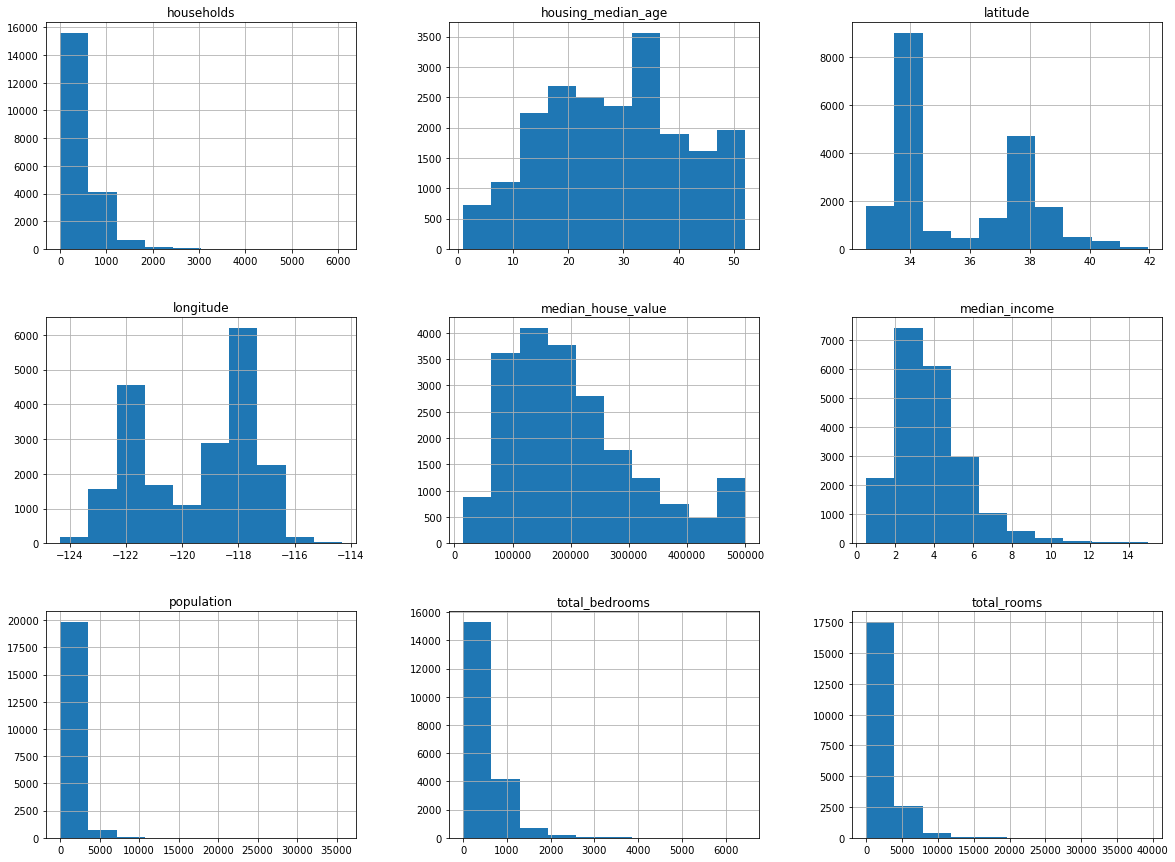

In [9]:
housing_data.hist(figsize=(20, 15))
plt.show()

In the graph below, the capping of `housing_median_age` and `median_house_value` is clearly visible.

In [ ]:
housing_data.hist(bins=50, figsize=(20, 15))
plt.show()

**TO DO** experiment with binning the values of these two predictors.

**TO DO** try using xgboost and see if it perfoms significantly better than random forests.

We could check whether the prices are very different for different locations.

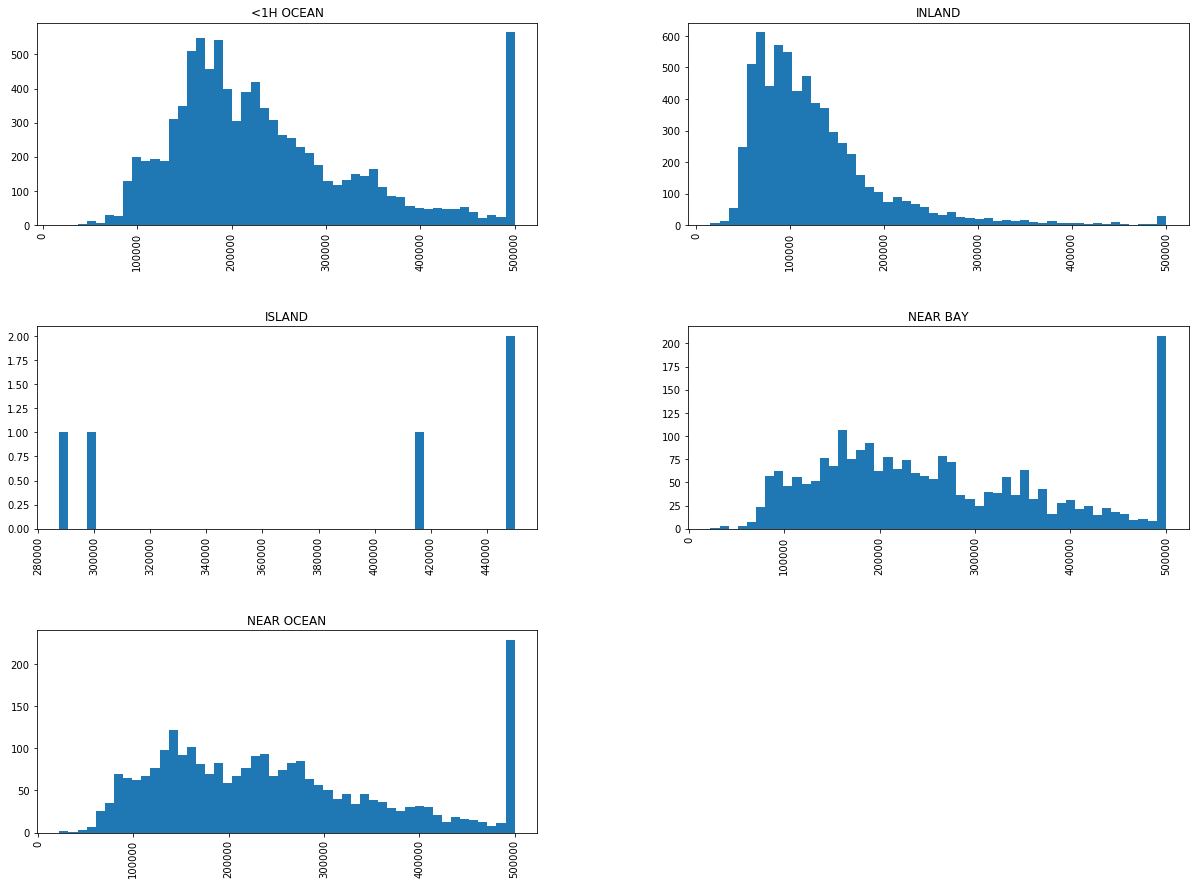

In [10]:
housing_data.median_house_value.hist(bins=50, by=housing_data.ocean_proximity,
                                     figsize=(20, 15))
plt.show()

Yes, it seems that inland houses are cheaper, and the peak for the high valued houses is not visible in that category.

In the `chapter2` module there is a `split_train_test_by_id` function that splits a dataset by crc32 hash. One example of its application is shown here.

In [11]:
housing_with_id = housing_data.reset_index()
train_set, test_set = ch2.split_train_test_by_id(housing_with_id, 0.2, 'index')
train_set.shape, test_set.shape

((16512, 11), (4128, 11))

Let's do it the "canonical" way.

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_data, test_size=0.2, random_state=42)

## Stratification


We create a categorical variable binning the `median_income` continuous variable.

In [13]:
housing_data['income_cat'] = np.ceil(housing_data['median_income'] / 1.5)
housing_data['income_cat'].value_counts().sort_index()

1.0      822
2.0     6581
3.0     7236
4.0     3639
5.0     1423
6.0      532
7.0      189
8.0      105
9.0       50
10.0      14
11.0      49
Name: income_cat, dtype: int64

We set the values of `income_cat` that are larger than 5.0 to 5.0. Note the peculiar way `pd.Series.where` works. When the condition is `True`, the value is retained. When it's `False`, the second argument is used instead. The opposite behaviour is obtained by `pd.Series.mask`.

In [15]:
housing_data['income_cat'].where(housing_data['income_cat'] < 5.0, 5.0, inplace=True)

The same result can be obtained more clearly by using `pd.cut`.

In [ ]:
housing_data['income_cat'] = pd.cut(housing_data['median_income'], 
                                    bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                    labels=[1, 2, 3, 4, 5])
housing_data['income_cat'].value_counts()

In the book, the class `StratifiedShuffleSplit` is used. This function returns the indices of the trianing and test sets. It turns out that the same result can be obtained more succintly by using `train_test_split` with the option `stratify`.

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housing_data, housing_data['income_cat']):
    strat_train_set = housing_data.loc[train_idx]
    strat_test_set = housing_data.loc[test_idx]

If we use `train_test_split` we obtain exactly the same entries in the stratified test set.

In [23]:
strat_train_set2, strat_test_set2 = train_test_split(housing_data, test_size=0.2,
                                                     random_state=42, 
                                                     stratify=housing_data['income_cat'])

In [24]:
print(np.all(strat_test_set.index == strat_test_set2.index))
del strat_train_set2, strat_test_set2

True


The stratification seems to work fine.

In [25]:
print(strat_train_set['income_cat'].value_counts(normalize=True))
print(strat_test_set['income_cat'].value_counts(normalize=True))

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


In [26]:
for dataset in (strat_train_set, strat_test_set):
    dataset.drop('income_cat', axis=1, inplace=True)

Let's create a copy of the training set we can play with without risks.

In [27]:
housing = strat_train_set.copy()

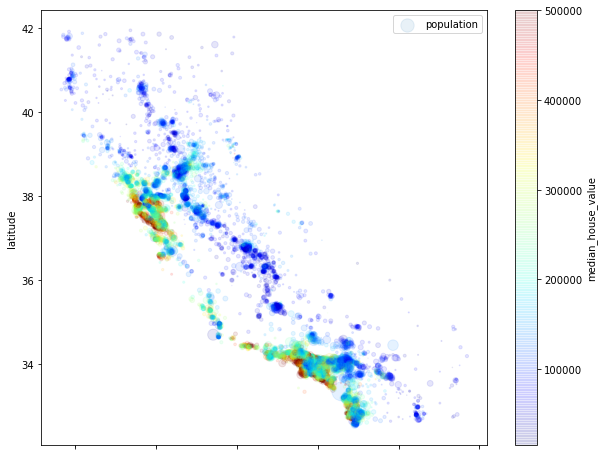

In [28]:
housing.plot(x='longitude', y='latitude', kind='scatter', alpha=0.1, figsize=(10, 8),
             s=housing['population']/100, c='median_house_value', cmap=plt.get_cmap('jet'),
             colorbar=True, label='population')
plt.legend()

In [29]:
corr_mat = housing.corr()
corr_mat['median_house_value']

longitude            -0.047432
latitude             -0.142724
housing_median_age    0.114110
total_rooms           0.135097
total_bedrooms        0.047689
population           -0.026920
households            0.064506
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

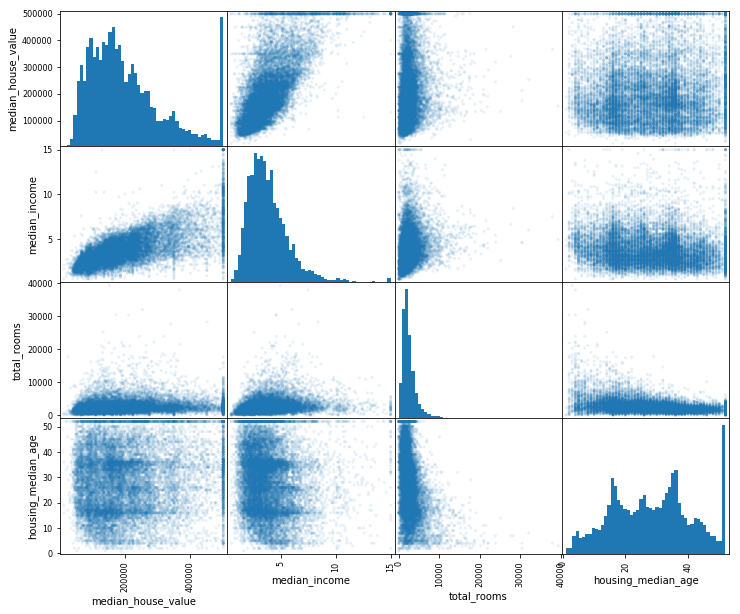

In [30]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], alpha=0.1, figsize=(12, 10), hist_kwds={'bins': 50})
plt.show()

## Adding features

We add a couple of additional features to those shown in the book.

In [31]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']
housing['rooms_per_population'] = housing['total_rooms'] / housing['population']
housing['bedrooms_per_population'] = housing['total_bedrooms'] / housing['population']

In [32]:
housing.corr()['median_house_value']

longitude                  -0.047432
latitude                   -0.142724
housing_median_age          0.114110
total_rooms                 0.135097
total_bedrooms              0.047689
population                 -0.026920
households                  0.064506
median_income               0.687160
median_house_value          1.000000
rooms_per_household         0.146285
bedrooms_per_room          -0.259984
population_per_household   -0.021985
rooms_per_population        0.199429
bedrooms_per_population     0.065419
Name: median_house_value, dtype: float64

The `rooms_per_population` feature seems to have a good positive correlation with the median price. If, however, we plot these two variables, the picture is quite different.

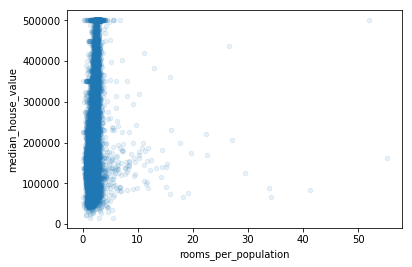

In [33]:
housing.plot(x='rooms_per_population', y='median_house_value', kind='scatter',
             alpha=0.1)
plt.show()

Turns out that taking the log of the house value doesn't make things better.

## Preparing the dataset for ML

In [36]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value']

### Missing values

We use the `SimpleImputer` class, but it would be interesting to play with a KNN classifier.

In [37]:
from sklearn.impute import SimpleImputer

We have missing values in `total_bedrooms` and in the variables built on it. **Note** that we impute the missing values *before* generating new features depending on `total_bedrooms`.

In [38]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [39]:
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [40]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

Note that we need to use the double bracket to produce a DataFrame, otherwise `OrdinalEncoder` will complain.

In [41]:
housing_cat = housing[['ocean_proximity']]

In [42]:
from sklearn.preprocessing import OrdinalEncoder

oenc = OrdinalEncoder()
housing_cat_encoded = oenc.fit_transform(housing_cat)

In [45]:
housing_cat_encoded

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

### One-hot encoding

Scikit-Learn's `OneHotEncoder` can now handle strings as inputs.

In [46]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
housing_cat_1hot = ohe.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The output is, by default, a sparse matrix. To have the dense representation we can use the `toarray` method.

In [47]:
housing_cat_1hot.toarray()[1:10]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

## Feature Scaling and numerical pipelines

We create a pipeline for the numeric features and one for the categorical ones. We then combine these pipelines into one.

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', ch2.CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Very interesting trick! If you take an object of class `pd.DataFrame` and you cast it into a list, you get a list of column names.

In [59]:
print(type(housing_num))
list(housing_num)

<class 'pandas.core.frame.DataFrame'>


['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

We can use the column names of the numeric and categorical featues and pass them to `ColumnTransformer`.

In [61]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs), # Don't need to put () next to num_pipeline
    ('cat', OneHotEncoder(), cat_attribs) # don't forget the () next to OneHotEncoder
])

housing_prepared = full_pipeline.fit_transform(housing)

## Linear Regression

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

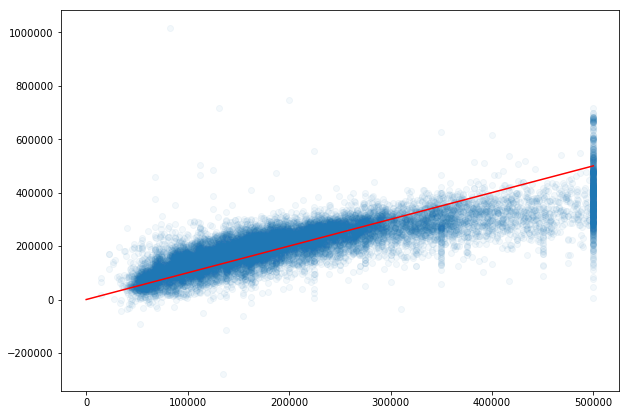

In [80]:
preds = lin_reg.predict(housing_prepared)
plt.figure(figsize=(10, 7))
plt.scatter(x = housing_labels, y = preds, alpha=0.05)
plt.plot(np.arange(0, 500000, 100), np.arange(0, 500000, 100), c='r') 

The linear regression captures the trend reasonable well in the range < 300,000, but then there is a clear deviation from linearity. We have also a number of outliers, with values very different from the predicted ones.

## Cross validation

We start running cross validation on a linear regression model, and then on some other models as well.

In [85]:
from sklearn.model_selection import cross_val_score

lr_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            cv=10, scoring='neg_mean_squared_error')

Note that we need to take the square root of the negative CV scores, since `cross_val_score` works with the `neg_mean_squared_error`.

In [95]:
ch2.display_scores(np.sqrt(-lr_scores))

Mean:   68217.3453126838
StdDev: 2385.7186372585493


In [90]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=7)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, n_jobs=4,
                               scoring='neg_mean_squared_error', cv=10)

In [96]:
ch2.display_scores(np.sqrt(-forest_scores))

Mean:   53419.92382387844
StdDev: 1804.3898179354733


If we want to save the model, the recommended way is to use `sklearn.externals.joblib`.

In [98]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor()
knn_scores = cross_val_score(knn_reg, housing_prepared, housing_labels, n_jobs=4,
                            scoring='neg_mean_squared_error', cv=10)
ch2.display_scores(np.sqrt(-knn_scores))

Mean:   59610.95306013587
StdDev: 1501.4535420257032


## Grid Search for the Random Forest Regressor

In [102]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [30, 50, 100], 'max_features': [8, 10, 12, 15]}
  ]

grid_search = GridSearchCV(forest_reg, param_grid, scoring='neg_mean_squared_error', 
                           n_jobs=4, cv=5, return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'n_estimators': [30, 50, 100], 'max_features': [8, 10, 12, 15]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [105]:
grid_search.best_params_

{'max_features': 10, 'n_estimators': 100}

In [104]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

50044.17732115967 {'max_features': 8, 'n_estimators': 30}
49647.4569134811 {'max_features': 8, 'n_estimators': 50}
49414.00456284921 {'max_features': 8, 'n_estimators': 100}
50076.11220177158 {'max_features': 10, 'n_estimators': 30}
49715.93044154529 {'max_features': 10, 'n_estimators': 50}
49280.33643647797 {'max_features': 10, 'n_estimators': 100}
50197.444877263435 {'max_features': 12, 'n_estimators': 30}
49570.75976800438 {'max_features': 12, 'n_estimators': 50}
49431.024113968655 {'max_features': 12, 'n_estimators': 100}
50268.54119333506 {'max_features': 15, 'n_estimators': 30}
49942.186785558195 {'max_features': 15, 'n_estimators': 50}
49452.371876930134 {'max_features': 15, 'n_estimators': 100}


## Feature Importance

Extracting feature importance from this model is a bit tricky. We can have the feature importance scores from the `best_estimator_` attribute of `grid_search`, but we need to build the names manually.

In [115]:
feature_importance = grid_search.best_estimator_.feature_importances_

The `full_pipeline` object has a `named_transformers_` attribute with the various transformers.

In [118]:
full_pipeline.named_transformers_

{'num': Pipeline(memory=None,
      steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
        strategy='median', verbose=0)), ('attribs_adder', CombinedAttributesAdder(add_bedrooms_per_room=True)), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]),
 'cat': OneHotEncoder(categorical_features=None, categories=None,
        dtype=<class 'numpy.float64'>, handle_unknown='error',
        n_values=None, sparse=True)}

In [131]:
cat_encoder = full_pipeline.named_transformers_['cat']
cat_attribs = list(cat_encoder.categories_[0])

We have also added some extra attributes in the pipeline by using the `CombinedAttributesAdder` class. More precisely we have:

In [132]:
extra_attribs = ['rooms_per_hh', 'pop_per_hh', 'beds_per_room', 'rooms_per_pop']

In [133]:
attributes = num_attribs + extra_attribs + cat_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.35357684728276473, 'median_income'),
 (0.16505105452812427, 'INLAND'),
 (0.10776621779395235, 'rooms_per_pop'),
 (0.0686333585257033, 'pop_per_hh'),
 (0.06603775851260613, 'longitude'),
 (0.06404020362319023, 'latitude'),
 (0.048498778730023194, 'beds_per_room'),
 (0.039636993577741066, 'housing_median_age'),
 (0.02747356557761018, 'rooms_per_hh'),
 (0.012868707702769716, 'total_rooms'),
 (0.012820063692697949, 'total_bedrooms'),
 (0.012648814327556603, 'population'),
 (0.01263622657402273, 'households'),
 (0.004433527403407876, '<1H OCEAN'),
 (0.0022872980725267044, 'NEAR OCEAN'),
 (0.0015073619999577965, 'NEAR BAY'),
 (8.322207534526332e-05, 'ISLAND')]

## Error Analysis

How can we perform error analysis on this dataset?

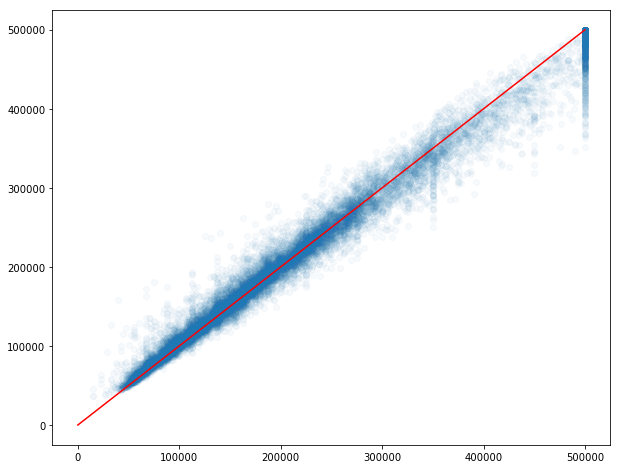

In [140]:
line_data = np.arange(0, 500_000, 100)
y_hat = grid_search.best_estimator_.predict(housing_prepared)
plt.figure(figsize=(10, 8))
plt.scatter(x=housing_labels, y=y_hat, alpha=0.03)
plt.plot(line_data, line_data, c='red')

The model captures much better the actual prices. There are some clear deviations, apparently due to the capped values. In the high end of the measurements we can still see some significant deviation.

## Evaluation on the test set


In [141]:
x_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [143]:
final_model = grid_search.best_estimator_
x_test_prep = full_pipeline.fit_transform(x_test)
final_predictions = final_model.predict(x_test_prep)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
